In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

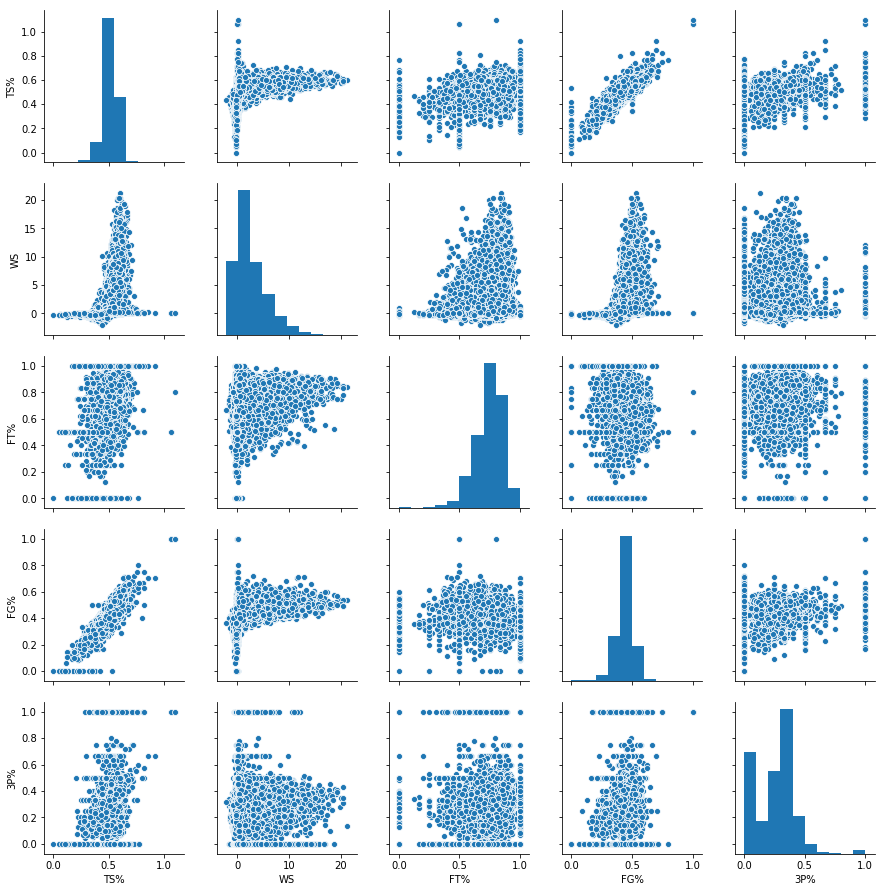

In [2]:
nba_df = pd.read_csv("Seasons_Stats.csv")
nba_df2= nba_df[['TS%', 'WS', 'FT%', 'FG%', '3P%']].copy()
nba_df2.dropna(inplace=True)
#sns.jointplot(df['Avg. Area Income'],df['Price'], alpha=0.02)
sns.pairplot(nba_df2)

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


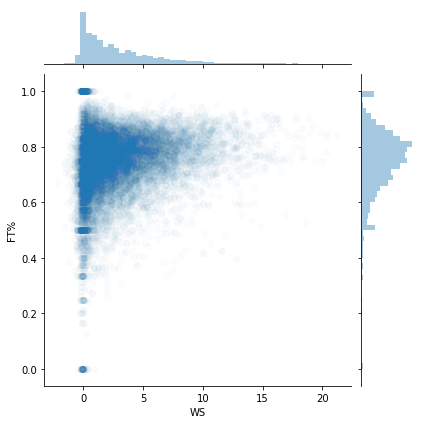

In [3]:
sns.jointplot(nba_df2['WS'],nba_df2['FT%'], alpha=0.02)

In [4]:
nba_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15116 entries, 5727 to 24690
Data columns (total 5 columns):
TS%    15116 non-null float64
WS     15116 non-null float64
FT%    15116 non-null float64
FG%    15116 non-null float64
3P%    15116 non-null float64
dtypes: float64(5)
memory usage: 1.3 MB


In [8]:
from azureml import Workspace

#by creating my ml and putting it online i can ping it from anywhere using api from anywhere in prdocution
# Replace the values with those from your own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the token is a long string of random characters.
workspace_id = '2ae2dd7801fc481eba5f316f50b52697'
authorization_token = 'aolv44EcQ7VeroUN+KVEjcmI3/Igk8mba6jq2nCp2jV85SQGJncVnaLZz9FAhM3LFwIpq7CSY3B2qcG2iwQaRA=='

ws = Workspace(workspace_id, authorization_token)

In [9]:
from azureml import DataTypeIds
dataset = ws.datasets.add_from_dataframe(
              dataframe=nba_df2,
              data_type_id=DataTypeIds.GenericCSV,
              name='Ball is Life',
              description='boing boing'
          )

In [10]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example]))

Forest Fire Data
Flight data
Flight data2
Ball is Life


In [11]:
ds = ws.datasets['Ball is Life']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df = ds.to_dataframe()
df.head()
df.info()
df = df.reset_index()

Ball is Life
boing boing
d4a651e34596448d9af9273f1f63c6eb
GenericCSV
2019-12-19 20:06:57.684000
599514
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15116 entries, 0 to 15115
Data columns (total 5 columns):
TS%    15116 non-null float64
WS     15116 non-null float64
FT%    15116 non-null float64
FG%    15116 non-null float64
3P%    15116 non-null float64
dtypes: float64(5)
memory usage: 590.5 KB


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[['TS%', 'FT%', 'FG%', '3P%']],
        df['WS'],
        test_size=0.25,
        random_state=42
    )

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted Win Shares: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted True Shooting percentage: -0.08


In [25]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(TS=float, FT=float, FG=float, ThreeP=float)
@services.returns(float)

# The name of your web service is set to this function's name
def win_share_predict(TS, FT, FG, ThreeP):
    return regressor.predict([TS, FT, FG, ThreeP])

# Hold onto information about your web service so 
# you can call it within the notebook later
service_url = win_share_predict.service.url 
api_key = win_share_predict.service.api_key
help_url = win_share_predict.service.help_url
service_id = win_share_predict.service.service_id

In [26]:
win_share_predict.service(0.6, 0.8, 0.5, 0.4)

5.9

The below will generate TS%

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[['FT%', 'FG%', '3P%']],
        df['TS%'],
        test_size=0.25,
        random_state=42
    )

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted True Shooting percentage: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted True Shooting percentage: 0.75


In [30]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(FT=float, FG=float, ThreeP=float)
@services.returns(float)

# The name of your web service is set to this function's name
def ts_predict(FT, FG, ThreeP):
    return regressor.predict([FT, FG, ThreeP])

# Hold onto information about your web service so 
# you can call it within the notebook later
service_url = ts_predict.service.url 
api_key = ts_predict.service.api_key
help_url = ts_predict.service.help_url
service_id = ts_predict.service.service_id

In [31]:
ts_predict.service(0.8, 0.5, 0.4)

0.601